# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

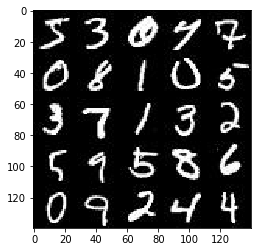

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

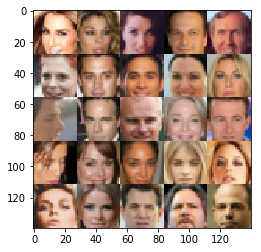

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/zhuweiping/miniconda2/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_ph = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z_ph = tf.placeholder(tf.float32, shape=(None, z_dim))
    lr_ph = tf.placeholder(tf.float32)
    return input_ph, z_ph, lr_ph


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    
    with tf.variable_scope('generator', reuse=not is_train):
    
        fc = tf.layers.dense(z, 7*7*256)
        fc = tf.reshape(fc, (-1, 7, 7, 256))
        fc = tf.layers.batch_normalization(fc, training=is_train)
        
        deconv2 = tf.layers.conv2d_transpose(fc, 128, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        deconv2 = tf.layers.batch_normalization(deconv2, training=is_train)
        deconv2 = tf.maximum(alpha*deconv2, deconv2)
        
        deconv3 = tf.layers.conv2d_transpose(deconv2, 64, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        deconv3 = tf.layers.batch_normalization(deconv3, training=is_train)
        deconv3 = tf.maximum(alpha*deconv3, deconv3)
        
        logits = tf.layers.conv2d_transpose(deconv3, out_channel_dim, 5, strides=1, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.tanh(logits)
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
     
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    show_every = 100
    print_every = 10
    n_images = 32
     
    n_samples, width, height, channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # reshape and re-scale bacth image
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:    
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode) 
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 1.1946... Generator Loss: 1.0717
Epoch 0/2... Discriminator Loss: 1.3439... Generator Loss: 0.7500
Epoch 0/2... Discriminator Loss: 2.4154... Generator Loss: 0.8227
Epoch 0/2... Discriminator Loss: 2.3716... Generator Loss: 0.1772
Epoch 0/2... Discriminator Loss: 1.5415... Generator Loss: 0.7199
Epoch 0/2... Discriminator Loss: 1.3643... Generator Loss: 0.7157
Epoch 0/2... Discriminator Loss: 1.3389... Generator Loss: 0.6759
Epoch 0/2... Discriminator Loss: 1.3933... Generator Loss: 0.9443
Epoch 0/2... Discriminator Loss: 1.7283... Generator Loss: 0.3738
Epoch 0/2... Discriminator Loss: 1.2057... Generator Loss: 1.1619


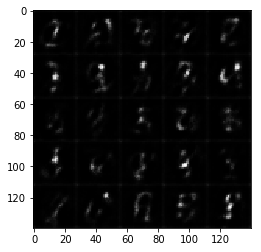

Epoch 0/2... Discriminator Loss: 1.3191... Generator Loss: 0.6483
Epoch 0/2... Discriminator Loss: 1.1612... Generator Loss: 1.0554
Epoch 0/2... Discriminator Loss: 1.1836... Generator Loss: 1.3219
Epoch 0/2... Discriminator Loss: 1.2207... Generator Loss: 0.8682
Epoch 0/2... Discriminator Loss: 1.1719... Generator Loss: 1.2395
Epoch 0/2... Discriminator Loss: 1.2371... Generator Loss: 0.7424
Epoch 0/2... Discriminator Loss: 1.0518... Generator Loss: 1.6024
Epoch 0/2... Discriminator Loss: 0.9892... Generator Loss: 1.2012
Epoch 0/2... Discriminator Loss: 1.3274... Generator Loss: 0.5424
Epoch 0/2... Discriminator Loss: 1.2658... Generator Loss: 2.0426


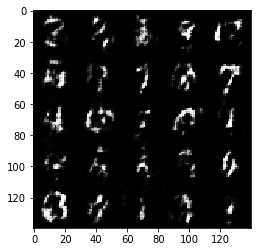

Epoch 0/2... Discriminator Loss: 1.0302... Generator Loss: 0.9918
Epoch 0/2... Discriminator Loss: 1.2919... Generator Loss: 1.8455
Epoch 0/2... Discriminator Loss: 1.2079... Generator Loss: 0.7104
Epoch 0/2... Discriminator Loss: 1.3322... Generator Loss: 0.7516
Epoch 0/2... Discriminator Loss: 1.1638... Generator Loss: 0.7778
Epoch 0/2... Discriminator Loss: 1.2122... Generator Loss: 1.3339
Epoch 0/2... Discriminator Loss: 1.1988... Generator Loss: 1.0499
Epoch 0/2... Discriminator Loss: 1.3222... Generator Loss: 1.2819
Epoch 0/2... Discriminator Loss: 1.4050... Generator Loss: 0.6844
Epoch 0/2... Discriminator Loss: 1.2480... Generator Loss: 0.8349


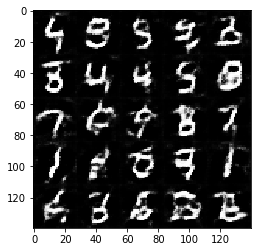

Epoch 0/2... Discriminator Loss: 1.0701... Generator Loss: 1.2143
Epoch 0/2... Discriminator Loss: 1.2969... Generator Loss: 0.9487
Epoch 0/2... Discriminator Loss: 1.3248... Generator Loss: 1.8462
Epoch 0/2... Discriminator Loss: 1.1614... Generator Loss: 0.8363
Epoch 0/2... Discriminator Loss: 1.0026... Generator Loss: 1.3245
Epoch 0/2... Discriminator Loss: 0.9831... Generator Loss: 1.1858
Epoch 0/2... Discriminator Loss: 1.1877... Generator Loss: 1.3362
Epoch 0/2... Discriminator Loss: 1.0115... Generator Loss: 1.2150
Epoch 0/2... Discriminator Loss: 1.0985... Generator Loss: 1.0839
Epoch 0/2... Discriminator Loss: 1.3185... Generator Loss: 0.6398


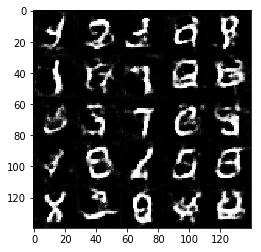

Epoch 0/2... Discriminator Loss: 1.1253... Generator Loss: 0.9356
Epoch 0/2... Discriminator Loss: 1.0447... Generator Loss: 1.1614
Epoch 0/2... Discriminator Loss: 1.2525... Generator Loss: 0.7058
Epoch 0/2... Discriminator Loss: 1.0120... Generator Loss: 0.9619
Epoch 0/2... Discriminator Loss: 0.9782... Generator Loss: 1.2477
Epoch 0/2... Discriminator Loss: 1.1874... Generator Loss: 0.7649
Epoch 0/2... Discriminator Loss: 1.3144... Generator Loss: 0.6608
Epoch 0/2... Discriminator Loss: 1.1670... Generator Loss: 0.8092
Epoch 0/2... Discriminator Loss: 1.0733... Generator Loss: 1.0822
Epoch 0/2... Discriminator Loss: 1.0160... Generator Loss: 0.9027


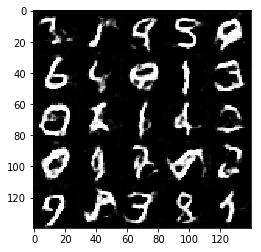

Epoch 0/2... Discriminator Loss: 1.1300... Generator Loss: 0.8650
Epoch 0/2... Discriminator Loss: 1.3700... Generator Loss: 0.6118
Epoch 0/2... Discriminator Loss: 1.0466... Generator Loss: 1.6292
Epoch 0/2... Discriminator Loss: 1.0130... Generator Loss: 1.3577
Epoch 0/2... Discriminator Loss: 0.9941... Generator Loss: 0.9633
Epoch 0/2... Discriminator Loss: 1.1637... Generator Loss: 0.9374
Epoch 0/2... Discriminator Loss: 1.1657... Generator Loss: 0.9793
Epoch 0/2... Discriminator Loss: 1.2398... Generator Loss: 0.6165
Epoch 0/2... Discriminator Loss: 1.0079... Generator Loss: 0.9986
Epoch 0/2... Discriminator Loss: 1.0751... Generator Loss: 0.8674


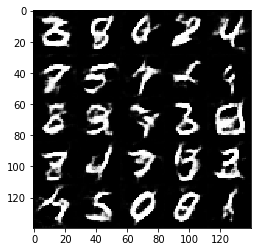

Epoch 0/2... Discriminator Loss: 1.1568... Generator Loss: 0.7684
Epoch 0/2... Discriminator Loss: 0.8964... Generator Loss: 1.4680
Epoch 0/2... Discriminator Loss: 0.9481... Generator Loss: 1.1489
Epoch 0/2... Discriminator Loss: 1.0095... Generator Loss: 0.9689
Epoch 0/2... Discriminator Loss: 1.4154... Generator Loss: 0.5067
Epoch 0/2... Discriminator Loss: 1.2231... Generator Loss: 0.8251
Epoch 0/2... Discriminator Loss: 1.1295... Generator Loss: 1.0667
Epoch 0/2... Discriminator Loss: 1.2014... Generator Loss: 0.8095
Epoch 0/2... Discriminator Loss: 1.0839... Generator Loss: 1.6775
Epoch 0/2... Discriminator Loss: 0.9679... Generator Loss: 0.9979


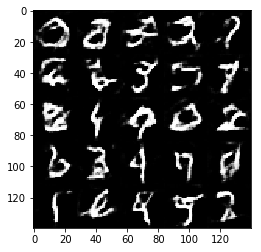

Epoch 0/2... Discriminator Loss: 1.1690... Generator Loss: 0.7224
Epoch 0/2... Discriminator Loss: 1.2488... Generator Loss: 0.6744
Epoch 0/2... Discriminator Loss: 1.0335... Generator Loss: 0.9756
Epoch 0/2... Discriminator Loss: 1.1250... Generator Loss: 2.6271
Epoch 0/2... Discriminator Loss: 1.4199... Generator Loss: 0.4892
Epoch 0/2... Discriminator Loss: 0.8987... Generator Loss: 1.1144
Epoch 0/2... Discriminator Loss: 0.8291... Generator Loss: 1.3195
Epoch 0/2... Discriminator Loss: 1.1037... Generator Loss: 0.8663
Epoch 0/2... Discriminator Loss: 0.9436... Generator Loss: 1.2704
Epoch 0/2... Discriminator Loss: 1.3912... Generator Loss: 1.7162


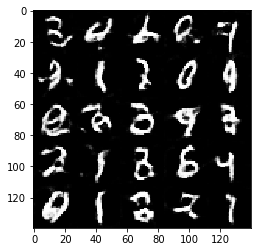

Epoch 0/2... Discriminator Loss: 1.0935... Generator Loss: 0.9643
Epoch 0/2... Discriminator Loss: 1.1535... Generator Loss: 1.0387
Epoch 0/2... Discriminator Loss: 1.1158... Generator Loss: 1.3113
Epoch 0/2... Discriminator Loss: 0.8873... Generator Loss: 1.2014
Epoch 0/2... Discriminator Loss: 0.8835... Generator Loss: 1.3222
Epoch 0/2... Discriminator Loss: 1.0479... Generator Loss: 1.3451
Epoch 0/2... Discriminator Loss: 1.2263... Generator Loss: 0.8273
Epoch 0/2... Discriminator Loss: 1.0448... Generator Loss: 0.9831
Epoch 0/2... Discriminator Loss: 0.9103... Generator Loss: 1.4528
Epoch 0/2... Discriminator Loss: 0.9105... Generator Loss: 1.1944


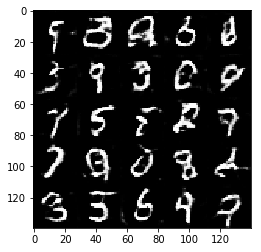

Epoch 0/2... Discriminator Loss: 1.6878... Generator Loss: 2.8026
Epoch 0/2... Discriminator Loss: 0.9382... Generator Loss: 1.2162
Epoch 0/2... Discriminator Loss: 0.9213... Generator Loss: 1.2383
Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 0.9124
Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 1.4488
Epoch 1/2... Discriminator Loss: 0.9472... Generator Loss: 0.9954
Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 1.5221
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 1.1518
Epoch 1/2... Discriminator Loss: 1.1308... Generator Loss: 0.8426
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 0.8299


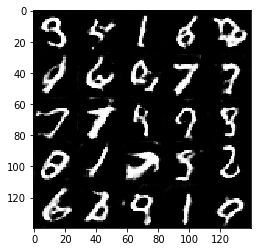

Epoch 1/2... Discriminator Loss: 0.9359... Generator Loss: 1.0857
Epoch 1/2... Discriminator Loss: 0.8811... Generator Loss: 1.0943
Epoch 1/2... Discriminator Loss: 0.8876... Generator Loss: 1.7934
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 0.6554
Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 2.3666
Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 1.1332
Epoch 1/2... Discriminator Loss: 0.9832... Generator Loss: 2.1797
Epoch 1/2... Discriminator Loss: 1.0832... Generator Loss: 0.9014
Epoch 1/2... Discriminator Loss: 0.8852... Generator Loss: 1.1545
Epoch 1/2... Discriminator Loss: 1.1028... Generator Loss: 0.7347


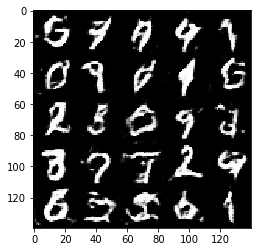

Epoch 1/2... Discriminator Loss: 0.8419... Generator Loss: 1.4454
Epoch 1/2... Discriminator Loss: 0.6921... Generator Loss: 1.5776
Epoch 1/2... Discriminator Loss: 0.6437... Generator Loss: 1.6760
Epoch 1/2... Discriminator Loss: 1.0860... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 0.8593... Generator Loss: 1.1657
Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.5982
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 1.1986
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.5707
Epoch 1/2... Discriminator Loss: 1.6577... Generator Loss: 0.4418
Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 0.9325


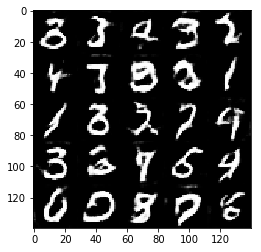

Epoch 1/2... Discriminator Loss: 0.7278... Generator Loss: 1.4605
Epoch 1/2... Discriminator Loss: 0.8006... Generator Loss: 1.6334
Epoch 1/2... Discriminator Loss: 0.9040... Generator Loss: 1.1859
Epoch 1/2... Discriminator Loss: 0.8518... Generator Loss: 1.0980
Epoch 1/2... Discriminator Loss: 0.7432... Generator Loss: 1.9007
Epoch 1/2... Discriminator Loss: 0.7892... Generator Loss: 1.8870
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 0.7479
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.5955
Epoch 1/2... Discriminator Loss: 0.8892... Generator Loss: 1.4208
Epoch 1/2... Discriminator Loss: 0.9608... Generator Loss: 2.2674


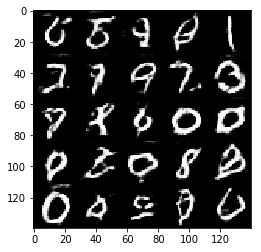

Epoch 1/2... Discriminator Loss: 0.9301... Generator Loss: 1.0444
Epoch 1/2... Discriminator Loss: 2.4455... Generator Loss: 2.9151
Epoch 1/2... Discriminator Loss: 0.9283... Generator Loss: 1.5203
Epoch 1/2... Discriminator Loss: 0.8612... Generator Loss: 1.4630
Epoch 1/2... Discriminator Loss: 1.1026... Generator Loss: 0.8068
Epoch 1/2... Discriminator Loss: 0.9737... Generator Loss: 1.0447
Epoch 1/2... Discriminator Loss: 0.8111... Generator Loss: 1.5774
Epoch 1/2... Discriminator Loss: 0.7577... Generator Loss: 1.4044
Epoch 1/2... Discriminator Loss: 0.8723... Generator Loss: 1.1378
Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 1.6600


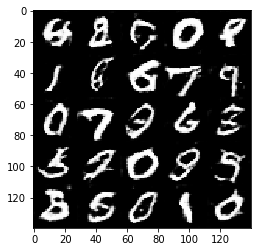

Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 0.9960
Epoch 1/2... Discriminator Loss: 0.7957... Generator Loss: 2.1861
Epoch 1/2... Discriminator Loss: 1.0620... Generator Loss: 0.8760
Epoch 1/2... Discriminator Loss: 0.6731... Generator Loss: 1.5136
Epoch 1/2... Discriminator Loss: 1.2783... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 0.8129... Generator Loss: 1.2600
Epoch 1/2... Discriminator Loss: 0.9611... Generator Loss: 0.9424
Epoch 1/2... Discriminator Loss: 0.8033... Generator Loss: 1.2841
Epoch 1/2... Discriminator Loss: 0.6861... Generator Loss: 1.8964
Epoch 1/2... Discriminator Loss: 0.6694... Generator Loss: 1.9629


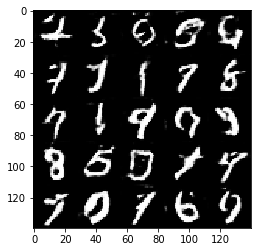

Epoch 1/2... Discriminator Loss: 0.9437... Generator Loss: 0.9964
Epoch 1/2... Discriminator Loss: 0.6586... Generator Loss: 1.5568
Epoch 1/2... Discriminator Loss: 0.6373... Generator Loss: 1.8468
Epoch 1/2... Discriminator Loss: 0.6179... Generator Loss: 1.7608
Epoch 1/2... Discriminator Loss: 1.1717... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 1.1327... Generator Loss: 1.4530
Epoch 1/2... Discriminator Loss: 1.2892... Generator Loss: 1.8569
Epoch 1/2... Discriminator Loss: 0.9257... Generator Loss: 1.6899
Epoch 1/2... Discriminator Loss: 1.1043... Generator Loss: 1.0520
Epoch 1/2... Discriminator Loss: 0.8068... Generator Loss: 1.3490


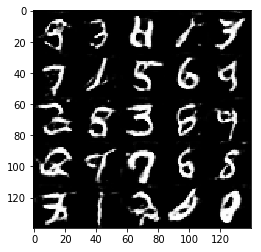

Epoch 1/2... Discriminator Loss: 1.2564... Generator Loss: 1.0066
Epoch 1/2... Discriminator Loss: 1.0000... Generator Loss: 2.3565
Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 1.4296
Epoch 1/2... Discriminator Loss: 0.8974... Generator Loss: 1.6976
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 0.7963
Epoch 1/2... Discriminator Loss: 0.7202... Generator Loss: 1.8944
Epoch 1/2... Discriminator Loss: 0.8343... Generator Loss: 1.2072
Epoch 1/2... Discriminator Loss: 0.8349... Generator Loss: 2.2867
Epoch 1/2... Discriminator Loss: 0.6425... Generator Loss: 1.6166
Epoch 1/2... Discriminator Loss: 1.0965... Generator Loss: 0.7763


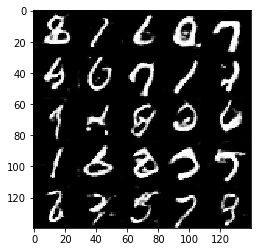

Epoch 1/2... Discriminator Loss: 1.1953... Generator Loss: 0.7243
Epoch 1/2... Discriminator Loss: 1.0957... Generator Loss: 0.8452
Epoch 1/2... Discriminator Loss: 1.1912... Generator Loss: 0.7274
Epoch 1/2... Discriminator Loss: 0.7977... Generator Loss: 2.3012
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 1.5865
Epoch 1/2... Discriminator Loss: 0.6153... Generator Loss: 1.7793
Epoch 1/2... Discriminator Loss: 0.6691... Generator Loss: 1.5904
Epoch 1/2... Discriminator Loss: 1.5821... Generator Loss: 0.5999
Epoch 1/2... Discriminator Loss: 0.5221... Generator Loss: 2.3775
Epoch 1/2... Discriminator Loss: 0.9465... Generator Loss: 1.3054


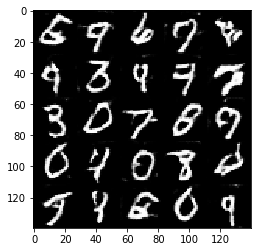

Epoch 1/2... Discriminator Loss: 1.0182... Generator Loss: 1.1702
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 0.8833
Epoch 1/2... Discriminator Loss: 0.9462... Generator Loss: 1.2197
Epoch 1/2... Discriminator Loss: 1.0597... Generator Loss: 0.8253
Epoch 1/2... Discriminator Loss: 0.7877... Generator Loss: 2.5798
Epoch 1/2... Discriminator Loss: 0.7185... Generator Loss: 1.5356
Epoch 1/2... Discriminator Loss: 0.6170... Generator Loss: 2.0193


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.3334... Generator Loss: 0.8484
Epoch 0/1... Discriminator Loss: 1.8512... Generator Loss: 1.4249
Epoch 0/1... Discriminator Loss: 2.2556... Generator Loss: 0.2484
Epoch 0/1... Discriminator Loss: 0.7552... Generator Loss: 1.8204
Epoch 0/1... Discriminator Loss: 1.1365... Generator Loss: 2.1333
Epoch 0/1... Discriminator Loss: 1.4227... Generator Loss: 0.5212
Epoch 0/1... Discriminator Loss: 1.0400... Generator Loss: 0.9578
Epoch 0/1... Discriminator Loss: 0.9210... Generator Loss: 2.2360
Epoch 0/1... Discriminator Loss: 1.4530... Generator Loss: 0.8294
Epoch 0/1... Discriminator Loss: 1.4214... Generator Loss: 0.6186


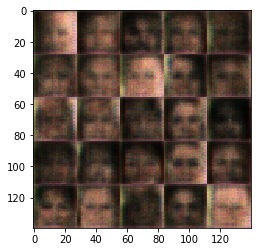

Epoch 0/1... Discriminator Loss: 1.0173... Generator Loss: 1.1478
Epoch 0/1... Discriminator Loss: 2.0283... Generator Loss: 2.4281
Epoch 0/1... Discriminator Loss: 1.1754... Generator Loss: 1.1355
Epoch 0/1... Discriminator Loss: 0.9893... Generator Loss: 1.7950
Epoch 0/1... Discriminator Loss: 1.1646... Generator Loss: 0.8687
Epoch 0/1... Discriminator Loss: 1.5288... Generator Loss: 1.6347
Epoch 0/1... Discriminator Loss: 1.8281... Generator Loss: 0.6074
Epoch 0/1... Discriminator Loss: 1.2552... Generator Loss: 0.6356
Epoch 0/1... Discriminator Loss: 0.9387... Generator Loss: 1.0913
Epoch 0/1... Discriminator Loss: 1.1422... Generator Loss: 0.8784


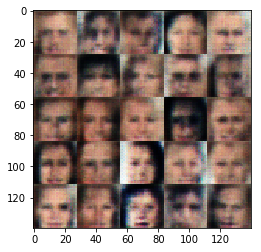

Epoch 0/1... Discriminator Loss: 1.3598... Generator Loss: 0.7776
Epoch 0/1... Discriminator Loss: 1.3948... Generator Loss: 0.9358
Epoch 0/1... Discriminator Loss: 1.2913... Generator Loss: 0.8560
Epoch 0/1... Discriminator Loss: 1.3286... Generator Loss: 0.7461
Epoch 0/1... Discriminator Loss: 1.2219... Generator Loss: 1.5004
Epoch 0/1... Discriminator Loss: 1.4060... Generator Loss: 0.5335
Epoch 0/1... Discriminator Loss: 1.3525... Generator Loss: 0.6963
Epoch 0/1... Discriminator Loss: 1.2382... Generator Loss: 0.7301
Epoch 0/1... Discriminator Loss: 1.6858... Generator Loss: 3.2310
Epoch 0/1... Discriminator Loss: 1.2413... Generator Loss: 0.6387


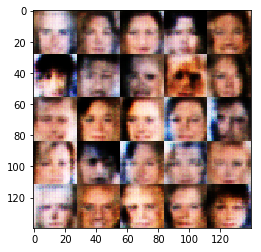

Epoch 0/1... Discriminator Loss: 1.2713... Generator Loss: 1.4389
Epoch 0/1... Discriminator Loss: 1.0512... Generator Loss: 0.9592
Epoch 0/1... Discriminator Loss: 1.5077... Generator Loss: 0.5704
Epoch 0/1... Discriminator Loss: 1.6663... Generator Loss: 0.3721
Epoch 0/1... Discriminator Loss: 0.6393... Generator Loss: 2.2108
Epoch 0/1... Discriminator Loss: 1.3786... Generator Loss: 0.7139
Epoch 0/1... Discriminator Loss: 1.6728... Generator Loss: 0.4349
Epoch 0/1... Discriminator Loss: 1.3137... Generator Loss: 0.8528
Epoch 0/1... Discriminator Loss: 2.0095... Generator Loss: 1.8211
Epoch 0/1... Discriminator Loss: 1.1024... Generator Loss: 0.9247


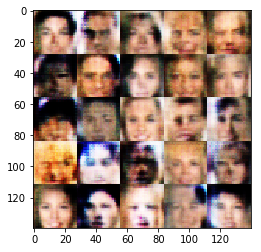

Epoch 0/1... Discriminator Loss: 1.2258... Generator Loss: 1.0729
Epoch 0/1... Discriminator Loss: 1.0987... Generator Loss: 1.1611
Epoch 0/1... Discriminator Loss: 1.4250... Generator Loss: 1.2686
Epoch 0/1... Discriminator Loss: 1.7729... Generator Loss: 0.6342
Epoch 0/1... Discriminator Loss: 1.1816... Generator Loss: 1.0929
Epoch 0/1... Discriminator Loss: 1.3444... Generator Loss: 0.9424
Epoch 0/1... Discriminator Loss: 1.6305... Generator Loss: 2.3357
Epoch 0/1... Discriminator Loss: 0.9915... Generator Loss: 1.8839
Epoch 0/1... Discriminator Loss: 2.0900... Generator Loss: 1.8159
Epoch 0/1... Discriminator Loss: 1.4169... Generator Loss: 0.5770


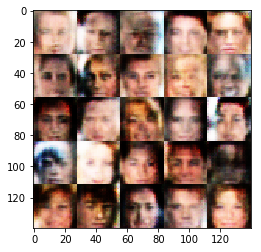

Epoch 0/1... Discriminator Loss: 1.1393... Generator Loss: 0.7494
Epoch 0/1... Discriminator Loss: 1.5300... Generator Loss: 1.8073
Epoch 0/1... Discriminator Loss: 1.3695... Generator Loss: 1.7252
Epoch 0/1... Discriminator Loss: 0.9922... Generator Loss: 1.0866
Epoch 0/1... Discriminator Loss: 0.8562... Generator Loss: 1.3081
Epoch 0/1... Discriminator Loss: 1.2970... Generator Loss: 0.6956
Epoch 0/1... Discriminator Loss: 1.4203... Generator Loss: 0.5559
Epoch 0/1... Discriminator Loss: 1.2149... Generator Loss: 0.7040
Epoch 0/1... Discriminator Loss: 1.0671... Generator Loss: 1.2259
Epoch 0/1... Discriminator Loss: 0.8687... Generator Loss: 1.3546


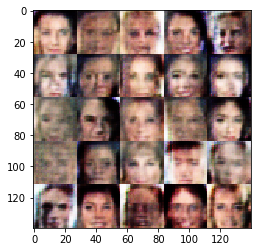

Epoch 0/1... Discriminator Loss: 1.2395... Generator Loss: 0.7026
Epoch 0/1... Discriminator Loss: 1.2182... Generator Loss: 0.9049
Epoch 0/1... Discriminator Loss: 1.7242... Generator Loss: 0.3348
Epoch 0/1... Discriminator Loss: 0.9525... Generator Loss: 1.0793
Epoch 0/1... Discriminator Loss: 1.0366... Generator Loss: 1.5850
Epoch 0/1... Discriminator Loss: 1.5485... Generator Loss: 0.5079
Epoch 0/1... Discriminator Loss: 1.1373... Generator Loss: 1.0562
Epoch 0/1... Discriminator Loss: 1.4538... Generator Loss: 0.9163
Epoch 0/1... Discriminator Loss: 1.3519... Generator Loss: 0.8087
Epoch 0/1... Discriminator Loss: 1.3113... Generator Loss: 0.8029


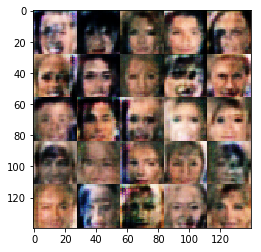

Epoch 0/1... Discriminator Loss: 1.3411... Generator Loss: 0.6915
Epoch 0/1... Discriminator Loss: 1.4972... Generator Loss: 0.5693
Epoch 0/1... Discriminator Loss: 1.2909... Generator Loss: 0.9767
Epoch 0/1... Discriminator Loss: 1.1877... Generator Loss: 0.7455
Epoch 0/1... Discriminator Loss: 1.2031... Generator Loss: 1.2753
Epoch 0/1... Discriminator Loss: 1.3107... Generator Loss: 0.7811
Epoch 0/1... Discriminator Loss: 1.0338... Generator Loss: 1.1347
Epoch 0/1... Discriminator Loss: 1.2161... Generator Loss: 1.1973
Epoch 0/1... Discriminator Loss: 1.2091... Generator Loss: 1.6759
Epoch 0/1... Discriminator Loss: 1.2465... Generator Loss: 0.8150


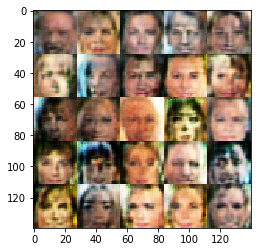

Epoch 0/1... Discriminator Loss: 1.2835... Generator Loss: 0.8214
Epoch 0/1... Discriminator Loss: 1.3294... Generator Loss: 0.7376
Epoch 0/1... Discriminator Loss: 1.3437... Generator Loss: 1.0258
Epoch 0/1... Discriminator Loss: 1.2733... Generator Loss: 0.7710
Epoch 0/1... Discriminator Loss: 1.2935... Generator Loss: 0.8648
Epoch 0/1... Discriminator Loss: 0.9687... Generator Loss: 1.5213
Epoch 0/1... Discriminator Loss: 1.4309... Generator Loss: 0.6363
Epoch 0/1... Discriminator Loss: 1.2725... Generator Loss: 0.8917
Epoch 0/1... Discriminator Loss: 1.3449... Generator Loss: 0.6343
Epoch 0/1... Discriminator Loss: 1.3601... Generator Loss: 0.7402


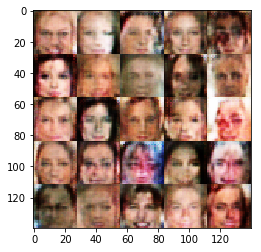

Epoch 0/1... Discriminator Loss: 1.1810... Generator Loss: 0.7918
Epoch 0/1... Discriminator Loss: 1.5148... Generator Loss: 0.8264
Epoch 0/1... Discriminator Loss: 1.3763... Generator Loss: 0.7911
Epoch 0/1... Discriminator Loss: 1.2239... Generator Loss: 0.8602
Epoch 0/1... Discriminator Loss: 1.1580... Generator Loss: 1.1039
Epoch 0/1... Discriminator Loss: 1.3406... Generator Loss: 0.7083
Epoch 0/1... Discriminator Loss: 1.2126... Generator Loss: 1.1835
Epoch 0/1... Discriminator Loss: 1.1958... Generator Loss: 0.7345
Epoch 0/1... Discriminator Loss: 1.4547... Generator Loss: 0.5272
Epoch 0/1... Discriminator Loss: 1.2485... Generator Loss: 0.9662


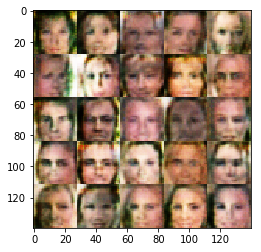

Epoch 0/1... Discriminator Loss: 1.2285... Generator Loss: 0.8735
Epoch 0/1... Discriminator Loss: 1.4256... Generator Loss: 0.5415
Epoch 0/1... Discriminator Loss: 1.2897... Generator Loss: 0.8013
Epoch 0/1... Discriminator Loss: 1.3153... Generator Loss: 0.8534
Epoch 0/1... Discriminator Loss: 1.3208... Generator Loss: 0.7675
Epoch 0/1... Discriminator Loss: 1.1815... Generator Loss: 1.2604
Epoch 0/1... Discriminator Loss: 1.3243... Generator Loss: 0.5902
Epoch 0/1... Discriminator Loss: 1.3642... Generator Loss: 0.6947
Epoch 0/1... Discriminator Loss: 1.1894... Generator Loss: 0.8976
Epoch 0/1... Discriminator Loss: 1.4823... Generator Loss: 0.6391


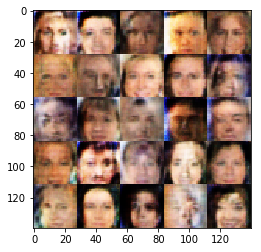

Epoch 0/1... Discriminator Loss: 1.2640... Generator Loss: 0.8277
Epoch 0/1... Discriminator Loss: 0.9878... Generator Loss: 1.2572
Epoch 0/1... Discriminator Loss: 1.5477... Generator Loss: 1.3801
Epoch 0/1... Discriminator Loss: 1.2737... Generator Loss: 0.6985
Epoch 0/1... Discriminator Loss: 1.4823... Generator Loss: 0.4865
Epoch 0/1... Discriminator Loss: 1.3889... Generator Loss: 0.5348
Epoch 0/1... Discriminator Loss: 1.3296... Generator Loss: 0.6136
Epoch 0/1... Discriminator Loss: 1.1057... Generator Loss: 0.9061
Epoch 0/1... Discriminator Loss: 1.3171... Generator Loss: 0.8178
Epoch 0/1... Discriminator Loss: 1.0251... Generator Loss: 1.0172


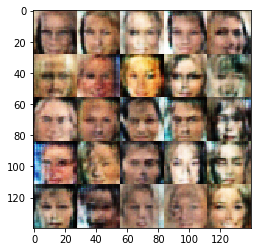

Epoch 0/1... Discriminator Loss: 1.0906... Generator Loss: 0.8670
Epoch 0/1... Discriminator Loss: 1.2949... Generator Loss: 0.7442
Epoch 0/1... Discriminator Loss: 1.3784... Generator Loss: 0.9637
Epoch 0/1... Discriminator Loss: 1.3434... Generator Loss: 0.7461
Epoch 0/1... Discriminator Loss: 1.2977... Generator Loss: 0.8590
Epoch 0/1... Discriminator Loss: 1.3327... Generator Loss: 0.8946
Epoch 0/1... Discriminator Loss: 1.3620... Generator Loss: 0.7312
Epoch 0/1... Discriminator Loss: 1.4626... Generator Loss: 0.5934
Epoch 0/1... Discriminator Loss: 1.3770... Generator Loss: 1.0209
Epoch 0/1... Discriminator Loss: 1.2525... Generator Loss: 1.0776


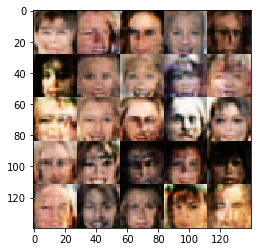

Epoch 0/1... Discriminator Loss: 1.3691... Generator Loss: 0.6272
Epoch 0/1... Discriminator Loss: 1.2818... Generator Loss: 0.6960
Epoch 0/1... Discriminator Loss: 1.1664... Generator Loss: 0.9375
Epoch 0/1... Discriminator Loss: 1.2507... Generator Loss: 0.8435
Epoch 0/1... Discriminator Loss: 1.3412... Generator Loss: 1.4227
Epoch 0/1... Discriminator Loss: 1.3023... Generator Loss: 0.7427
Epoch 0/1... Discriminator Loss: 1.3063... Generator Loss: 0.7282
Epoch 0/1... Discriminator Loss: 1.2295... Generator Loss: 0.6903
Epoch 0/1... Discriminator Loss: 1.2156... Generator Loss: 1.1317
Epoch 0/1... Discriminator Loss: 1.2732... Generator Loss: 0.9161


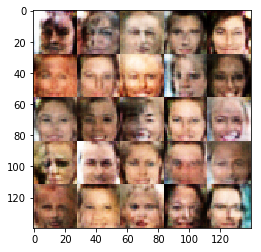

Epoch 0/1... Discriminator Loss: 1.2968... Generator Loss: 0.6619
Epoch 0/1... Discriminator Loss: 1.5282... Generator Loss: 0.6241
Epoch 0/1... Discriminator Loss: 1.2174... Generator Loss: 1.2073
Epoch 0/1... Discriminator Loss: 1.5828... Generator Loss: 1.4624
Epoch 0/1... Discriminator Loss: 1.2745... Generator Loss: 0.7838
Epoch 0/1... Discriminator Loss: 1.3120... Generator Loss: 0.9663
Epoch 0/1... Discriminator Loss: 1.2544... Generator Loss: 0.9798
Epoch 0/1... Discriminator Loss: 1.2756... Generator Loss: 0.6972
Epoch 0/1... Discriminator Loss: 1.2943... Generator Loss: 0.8402
Epoch 0/1... Discriminator Loss: 1.3781... Generator Loss: 0.6252


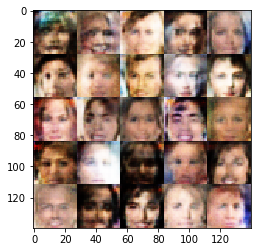

Epoch 0/1... Discriminator Loss: 1.4313... Generator Loss: 0.5973
Epoch 0/1... Discriminator Loss: 1.0208... Generator Loss: 1.1948
Epoch 0/1... Discriminator Loss: 1.2342... Generator Loss: 0.7906
Epoch 0/1... Discriminator Loss: 1.0883... Generator Loss: 1.0449
Epoch 0/1... Discriminator Loss: 1.3982... Generator Loss: 0.5712
Epoch 0/1... Discriminator Loss: 1.4544... Generator Loss: 0.5039
Epoch 0/1... Discriminator Loss: 1.1868... Generator Loss: 0.9378
Epoch 0/1... Discriminator Loss: 1.2395... Generator Loss: 0.8217
Epoch 0/1... Discriminator Loss: 1.2818... Generator Loss: 0.9785
Epoch 0/1... Discriminator Loss: 1.2430... Generator Loss: 0.9899


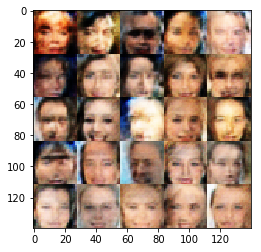

Epoch 0/1... Discriminator Loss: 1.2233... Generator Loss: 0.8393
Epoch 0/1... Discriminator Loss: 1.3130... Generator Loss: 1.1128
Epoch 0/1... Discriminator Loss: 1.0747... Generator Loss: 1.0831
Epoch 0/1... Discriminator Loss: 1.2431... Generator Loss: 1.1117
Epoch 0/1... Discriminator Loss: 1.3311... Generator Loss: 0.6525
Epoch 0/1... Discriminator Loss: 1.2592... Generator Loss: 0.8422
Epoch 0/1... Discriminator Loss: 1.2907... Generator Loss: 0.8722
Epoch 0/1... Discriminator Loss: 1.2235... Generator Loss: 1.1939
Epoch 0/1... Discriminator Loss: 1.2297... Generator Loss: 0.7321
Epoch 0/1... Discriminator Loss: 1.3002... Generator Loss: 0.6729


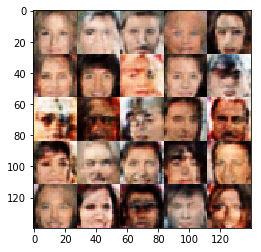

Epoch 0/1... Discriminator Loss: 1.1350... Generator Loss: 1.0119
Epoch 0/1... Discriminator Loss: 1.2537... Generator Loss: 1.0050
Epoch 0/1... Discriminator Loss: 1.2324... Generator Loss: 0.9593
Epoch 0/1... Discriminator Loss: 1.2414... Generator Loss: 0.9713
Epoch 0/1... Discriminator Loss: 1.3646... Generator Loss: 0.8221
Epoch 0/1... Discriminator Loss: 1.1676... Generator Loss: 1.0915
Epoch 0/1... Discriminator Loss: 1.2016... Generator Loss: 1.1723
Epoch 0/1... Discriminator Loss: 1.2660... Generator Loss: 1.1264
Epoch 0/1... Discriminator Loss: 1.2424... Generator Loss: 0.9217
Epoch 0/1... Discriminator Loss: 1.3224... Generator Loss: 0.6360


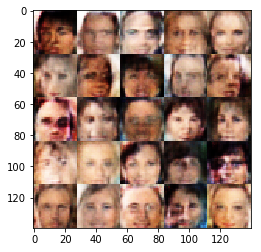

Epoch 0/1... Discriminator Loss: 1.1674... Generator Loss: 1.1474
Epoch 0/1... Discriminator Loss: 1.3846... Generator Loss: 0.7682
Epoch 0/1... Discriminator Loss: 1.2550... Generator Loss: 0.7919
Epoch 0/1... Discriminator Loss: 1.2566... Generator Loss: 0.7091
Epoch 0/1... Discriminator Loss: 1.3173... Generator Loss: 0.5881
Epoch 0/1... Discriminator Loss: 1.2985... Generator Loss: 0.7777
Epoch 0/1... Discriminator Loss: 1.4560... Generator Loss: 0.4937
Epoch 0/1... Discriminator Loss: 1.1791... Generator Loss: 0.9704
Epoch 0/1... Discriminator Loss: 1.3335... Generator Loss: 0.9619
Epoch 0/1... Discriminator Loss: 1.1858... Generator Loss: 1.1040


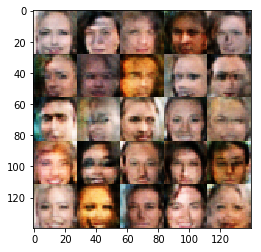

Epoch 0/1... Discriminator Loss: 1.0924... Generator Loss: 0.8960
Epoch 0/1... Discriminator Loss: 1.3421... Generator Loss: 0.5886
Epoch 0/1... Discriminator Loss: 1.0973... Generator Loss: 0.9908
Epoch 0/1... Discriminator Loss: 1.1620... Generator Loss: 0.8801
Epoch 0/1... Discriminator Loss: 1.2398... Generator Loss: 0.9850
Epoch 0/1... Discriminator Loss: 1.2365... Generator Loss: 1.0615
Epoch 0/1... Discriminator Loss: 1.0587... Generator Loss: 0.8882
Epoch 0/1... Discriminator Loss: 1.1718... Generator Loss: 0.8108
Epoch 0/1... Discriminator Loss: 1.2700... Generator Loss: 0.7415
Epoch 0/1... Discriminator Loss: 1.4807... Generator Loss: 0.4922


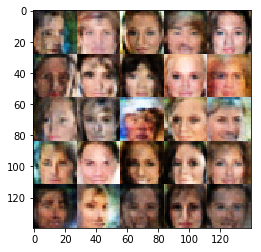

Epoch 0/1... Discriminator Loss: 1.1326... Generator Loss: 0.8718
Epoch 0/1... Discriminator Loss: 1.3007... Generator Loss: 0.8085
Epoch 0/1... Discriminator Loss: 1.0679... Generator Loss: 1.0179
Epoch 0/1... Discriminator Loss: 1.2547... Generator Loss: 0.7563
Epoch 0/1... Discriminator Loss: 1.1652... Generator Loss: 0.9043
Epoch 0/1... Discriminator Loss: 1.2311... Generator Loss: 0.6855
Epoch 0/1... Discriminator Loss: 1.4025... Generator Loss: 0.5637
Epoch 0/1... Discriminator Loss: 1.3527... Generator Loss: 0.5592
Epoch 0/1... Discriminator Loss: 1.5719... Generator Loss: 0.5015
Epoch 0/1... Discriminator Loss: 1.0356... Generator Loss: 1.2825


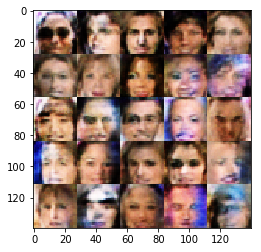

Epoch 0/1... Discriminator Loss: 1.1880... Generator Loss: 0.7890
Epoch 0/1... Discriminator Loss: 1.1085... Generator Loss: 1.1637
Epoch 0/1... Discriminator Loss: 1.4589... Generator Loss: 0.4988
Epoch 0/1... Discriminator Loss: 1.1352... Generator Loss: 0.9409
Epoch 0/1... Discriminator Loss: 1.1811... Generator Loss: 0.7765
Epoch 0/1... Discriminator Loss: 1.2474... Generator Loss: 0.6607
Epoch 0/1... Discriminator Loss: 1.1209... Generator Loss: 1.1530
Epoch 0/1... Discriminator Loss: 1.0648... Generator Loss: 0.8440
Epoch 0/1... Discriminator Loss: 1.2433... Generator Loss: 0.8920
Epoch 0/1... Discriminator Loss: 1.1838... Generator Loss: 0.8160


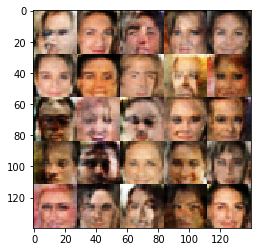

Epoch 0/1... Discriminator Loss: 1.1271... Generator Loss: 0.9660
Epoch 0/1... Discriminator Loss: 1.1846... Generator Loss: 0.7415
Epoch 0/1... Discriminator Loss: 1.3226... Generator Loss: 0.8714
Epoch 0/1... Discriminator Loss: 1.1438... Generator Loss: 1.2001
Epoch 0/1... Discriminator Loss: 1.2155... Generator Loss: 0.7796
Epoch 0/1... Discriminator Loss: 1.2318... Generator Loss: 1.2148
Epoch 0/1... Discriminator Loss: 1.3837... Generator Loss: 0.5394
Epoch 0/1... Discriminator Loss: 1.1851... Generator Loss: 0.8331
Epoch 0/1... Discriminator Loss: 0.9179... Generator Loss: 1.1489
Epoch 0/1... Discriminator Loss: 1.1832... Generator Loss: 1.0100


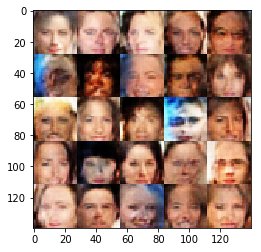

Epoch 0/1... Discriminator Loss: 1.4450... Generator Loss: 0.7610
Epoch 0/1... Discriminator Loss: 1.2547... Generator Loss: 0.7202
Epoch 0/1... Discriminator Loss: 1.1745... Generator Loss: 1.0540
Epoch 0/1... Discriminator Loss: 1.3480... Generator Loss: 1.5874
Epoch 0/1... Discriminator Loss: 1.2316... Generator Loss: 0.8204
Epoch 0/1... Discriminator Loss: 1.2784... Generator Loss: 0.9374
Epoch 0/1... Discriminator Loss: 1.4013... Generator Loss: 0.5771
Epoch 0/1... Discriminator Loss: 1.0791... Generator Loss: 0.9147
Epoch 0/1... Discriminator Loss: 1.1333... Generator Loss: 1.1210
Epoch 0/1... Discriminator Loss: 1.3355... Generator Loss: 0.9321


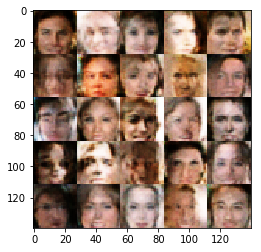

Epoch 0/1... Discriminator Loss: 1.0907... Generator Loss: 1.1864
Epoch 0/1... Discriminator Loss: 1.5466... Generator Loss: 0.4739
Epoch 0/1... Discriminator Loss: 1.5514... Generator Loss: 1.7496
Epoch 0/1... Discriminator Loss: 1.2741... Generator Loss: 0.8873
Epoch 0/1... Discriminator Loss: 1.1901... Generator Loss: 1.1074
Epoch 0/1... Discriminator Loss: 1.4013... Generator Loss: 0.5582
Epoch 0/1... Discriminator Loss: 1.4256... Generator Loss: 0.5396
Epoch 0/1... Discriminator Loss: 1.0999... Generator Loss: 1.0820
Epoch 0/1... Discriminator Loss: 1.0729... Generator Loss: 0.9145
Epoch 0/1... Discriminator Loss: 1.3339... Generator Loss: 0.8440


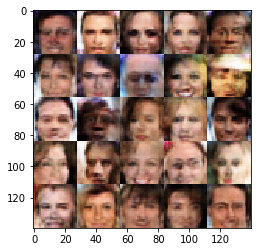

Epoch 0/1... Discriminator Loss: 1.0988... Generator Loss: 1.1172
Epoch 0/1... Discriminator Loss: 1.2120... Generator Loss: 0.9363
Epoch 0/1... Discriminator Loss: 1.0307... Generator Loss: 1.3624
Epoch 0/1... Discriminator Loss: 1.2725... Generator Loss: 0.8932
Epoch 0/1... Discriminator Loss: 1.3072... Generator Loss: 0.6637
Epoch 0/1... Discriminator Loss: 1.4476... Generator Loss: 0.8486
Epoch 0/1... Discriminator Loss: 1.3911... Generator Loss: 0.7749
Epoch 0/1... Discriminator Loss: 0.9752... Generator Loss: 1.1888
Epoch 0/1... Discriminator Loss: 1.1978... Generator Loss: 0.8346
Epoch 0/1... Discriminator Loss: 1.3669... Generator Loss: 0.6125


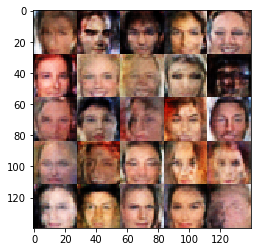

Epoch 0/1... Discriminator Loss: 1.1093... Generator Loss: 0.9036
Epoch 0/1... Discriminator Loss: 1.2437... Generator Loss: 0.8590
Epoch 0/1... Discriminator Loss: 1.0629... Generator Loss: 0.9026
Epoch 0/1... Discriminator Loss: 1.4080... Generator Loss: 0.5815
Epoch 0/1... Discriminator Loss: 1.1839... Generator Loss: 1.2544
Epoch 0/1... Discriminator Loss: 1.0534... Generator Loss: 1.1062
Epoch 0/1... Discriminator Loss: 1.0439... Generator Loss: 0.9641
Epoch 0/1... Discriminator Loss: 1.2158... Generator Loss: 0.9290
Epoch 0/1... Discriminator Loss: 1.2307... Generator Loss: 0.7826
Epoch 0/1... Discriminator Loss: 1.1164... Generator Loss: 0.9611


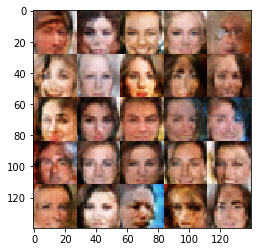

Epoch 0/1... Discriminator Loss: 1.2005... Generator Loss: 0.8970
Epoch 0/1... Discriminator Loss: 1.2866... Generator Loss: 0.6617
Epoch 0/1... Discriminator Loss: 1.3421... Generator Loss: 0.5876
Epoch 0/1... Discriminator Loss: 1.0283... Generator Loss: 1.1818
Epoch 0/1... Discriminator Loss: 1.2216... Generator Loss: 0.7913
Epoch 0/1... Discriminator Loss: 1.3300... Generator Loss: 1.3264
Epoch 0/1... Discriminator Loss: 1.0911... Generator Loss: 0.9377
Epoch 0/1... Discriminator Loss: 1.2368... Generator Loss: 0.8003
Epoch 0/1... Discriminator Loss: 1.3109... Generator Loss: 0.9871
Epoch 0/1... Discriminator Loss: 1.0541... Generator Loss: 1.1488


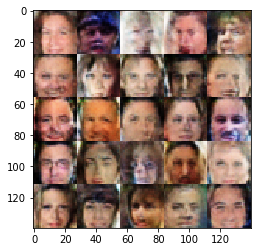

Epoch 0/1... Discriminator Loss: 1.3488... Generator Loss: 0.6121
Epoch 0/1... Discriminator Loss: 1.0915... Generator Loss: 0.9905
Epoch 0/1... Discriminator Loss: 0.9095... Generator Loss: 1.5513
Epoch 0/1... Discriminator Loss: 1.3454... Generator Loss: 0.6012
Epoch 0/1... Discriminator Loss: 1.1920... Generator Loss: 0.7271
Epoch 0/1... Discriminator Loss: 1.1690... Generator Loss: 0.9687
Epoch 0/1... Discriminator Loss: 1.2210... Generator Loss: 0.9005
Epoch 0/1... Discriminator Loss: 1.0234... Generator Loss: 1.2148
Epoch 0/1... Discriminator Loss: 1.3392... Generator Loss: 0.5906
Epoch 0/1... Discriminator Loss: 1.2608... Generator Loss: 0.8031


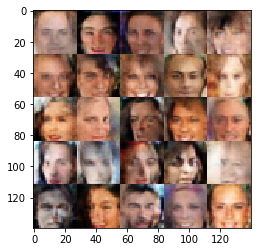

Epoch 0/1... Discriminator Loss: 1.2563... Generator Loss: 1.0794
Epoch 0/1... Discriminator Loss: 1.1142... Generator Loss: 0.9629
Epoch 0/1... Discriminator Loss: 1.1754... Generator Loss: 0.8576
Epoch 0/1... Discriminator Loss: 1.5488... Generator Loss: 1.6329
Epoch 0/1... Discriminator Loss: 1.1159... Generator Loss: 0.8477
Epoch 0/1... Discriminator Loss: 1.0230... Generator Loss: 1.3081
Epoch 0/1... Discriminator Loss: 1.1161... Generator Loss: 0.9380
Epoch 0/1... Discriminator Loss: 1.1696... Generator Loss: 0.8402
Epoch 0/1... Discriminator Loss: 1.2687... Generator Loss: 0.7818
Epoch 0/1... Discriminator Loss: 1.3705... Generator Loss: 0.6437


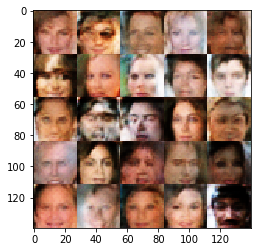

Epoch 0/1... Discriminator Loss: 1.3982... Generator Loss: 1.7496
Epoch 0/1... Discriminator Loss: 1.1182... Generator Loss: 0.8029
Epoch 0/1... Discriminator Loss: 1.3489... Generator Loss: 1.0358
Epoch 0/1... Discriminator Loss: 1.2139... Generator Loss: 0.7847
Epoch 0/1... Discriminator Loss: 1.0789... Generator Loss: 1.1305
Epoch 0/1... Discriminator Loss: 1.2030... Generator Loss: 0.7975
Epoch 0/1... Discriminator Loss: 1.6484... Generator Loss: 0.6514
Epoch 0/1... Discriminator Loss: 0.9713... Generator Loss: 1.2203
Epoch 0/1... Discriminator Loss: 1.1892... Generator Loss: 0.9023
Epoch 0/1... Discriminator Loss: 1.2966... Generator Loss: 0.6787


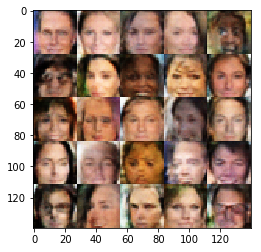

Epoch 0/1... Discriminator Loss: 1.2620... Generator Loss: 0.6891
Epoch 0/1... Discriminator Loss: 1.1305... Generator Loss: 0.7795
Epoch 0/1... Discriminator Loss: 1.1411... Generator Loss: 0.9571
Epoch 0/1... Discriminator Loss: 1.1549... Generator Loss: 0.8307
Epoch 0/1... Discriminator Loss: 1.3462... Generator Loss: 0.7118
Epoch 0/1... Discriminator Loss: 1.4400... Generator Loss: 0.5409


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.